In [1]:
# Load moduls
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from math import nan

from imblearn.pipeline import Pipeline 

from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)
plt.style.use('bmh')

In [2]:
# Read data
path = '../data/processed/combined_data.csv'
df = pd.read_csv(path, index_col='date', parse_dates=True)

## Calculate price elasticity

In [3]:
# Price elasticity cacao
demand = df.loc[:, 'Umsatz_WZ08-1082']
price = df.loc[:, 'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.']
demand_change = demand.pct_change()
price_change = price.pct_change()
elasticity = demand_change / price_change
df['elasticity_cacao'] = elasticity
median_elast_cacao = df['elasticity_cacao'].median()
df['elasticity_cacao'] = df['elasticity_cacao'].fillna(median_elast_cacao)
print('Median cacao elasticty: ', median_elast_cacao)

# Price elasticity coffee
demand_coffee = df.loc[:, 'Umsatz_WZ08-1083']
price_coffee = df.loc[:, 'Wert der zum Absatz bestimmten Produktion_Kaffee, geröstet']
demand_change_coffee = demand_coffee.pct_change()
price_change_coffee = price_coffee.pct_change()
elasticity_coffee = demand_change_coffee / price_change_coffee
df['elasticity_coffee'] = elasticity_coffee
median_elast_coffee = df['elasticity_coffee'].median()
df['elasticity_coffee'] = df['elasticity_coffee'].fillna(median_elast_coffee)
print('Median coffee elasticty: ', median_elast_coffee)

Median cacao elasticty:  0.2071867682976029
Median coffee elasticty:  0.09255010807384499


C:\Users\judit\AppData\Local\Temp\ipykernel_16360\2265180124.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  demand_change = demand.pct_change()
C:\Users\judit\AppData\Local\Temp\ipykernel_16360\2265180124.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_change = price.pct_change()
C:\Users\judit\AppData\Local\Temp\ipykernel_16360\2265180124.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA val

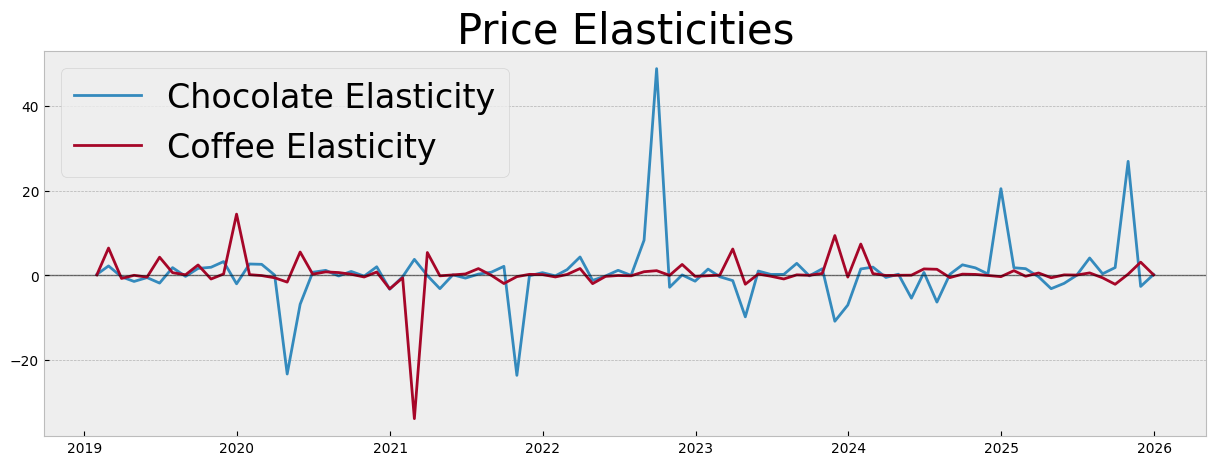

In [4]:
# Plot elasticities
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(df.index,df.elasticity_cacao.values, label = 'Chocolate Elasticity')
ax.plot(df.index,df.elasticity_coffee.values, label = 'Coffee Elasticity')
ax.axhline(0, linewidth = 1, color = 'black', alpha = 0.5)
#plt.xticks(rotation=90)
ax.set_title('Price Elasticities', fontsize=30)
ax.legend(fontsize = 24);
ax.grid(visible=False, axis='x')

## Add month 

In [61]:
df['month'] = df.index.month.values

## Save

In [62]:
# saving data
df.to_csv('../data/processed/combined_data_with_elasticity.csv')

## Why including lag is sensible

The following heatmaps show the correlation between the elasticities and the share prices of cacao resp. coffee. The share prices are lagged by different numbers to show that the highest correlations are not necessarily achieved with the not-lagged version. 

### Global cacoa prices

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


<Axes: >

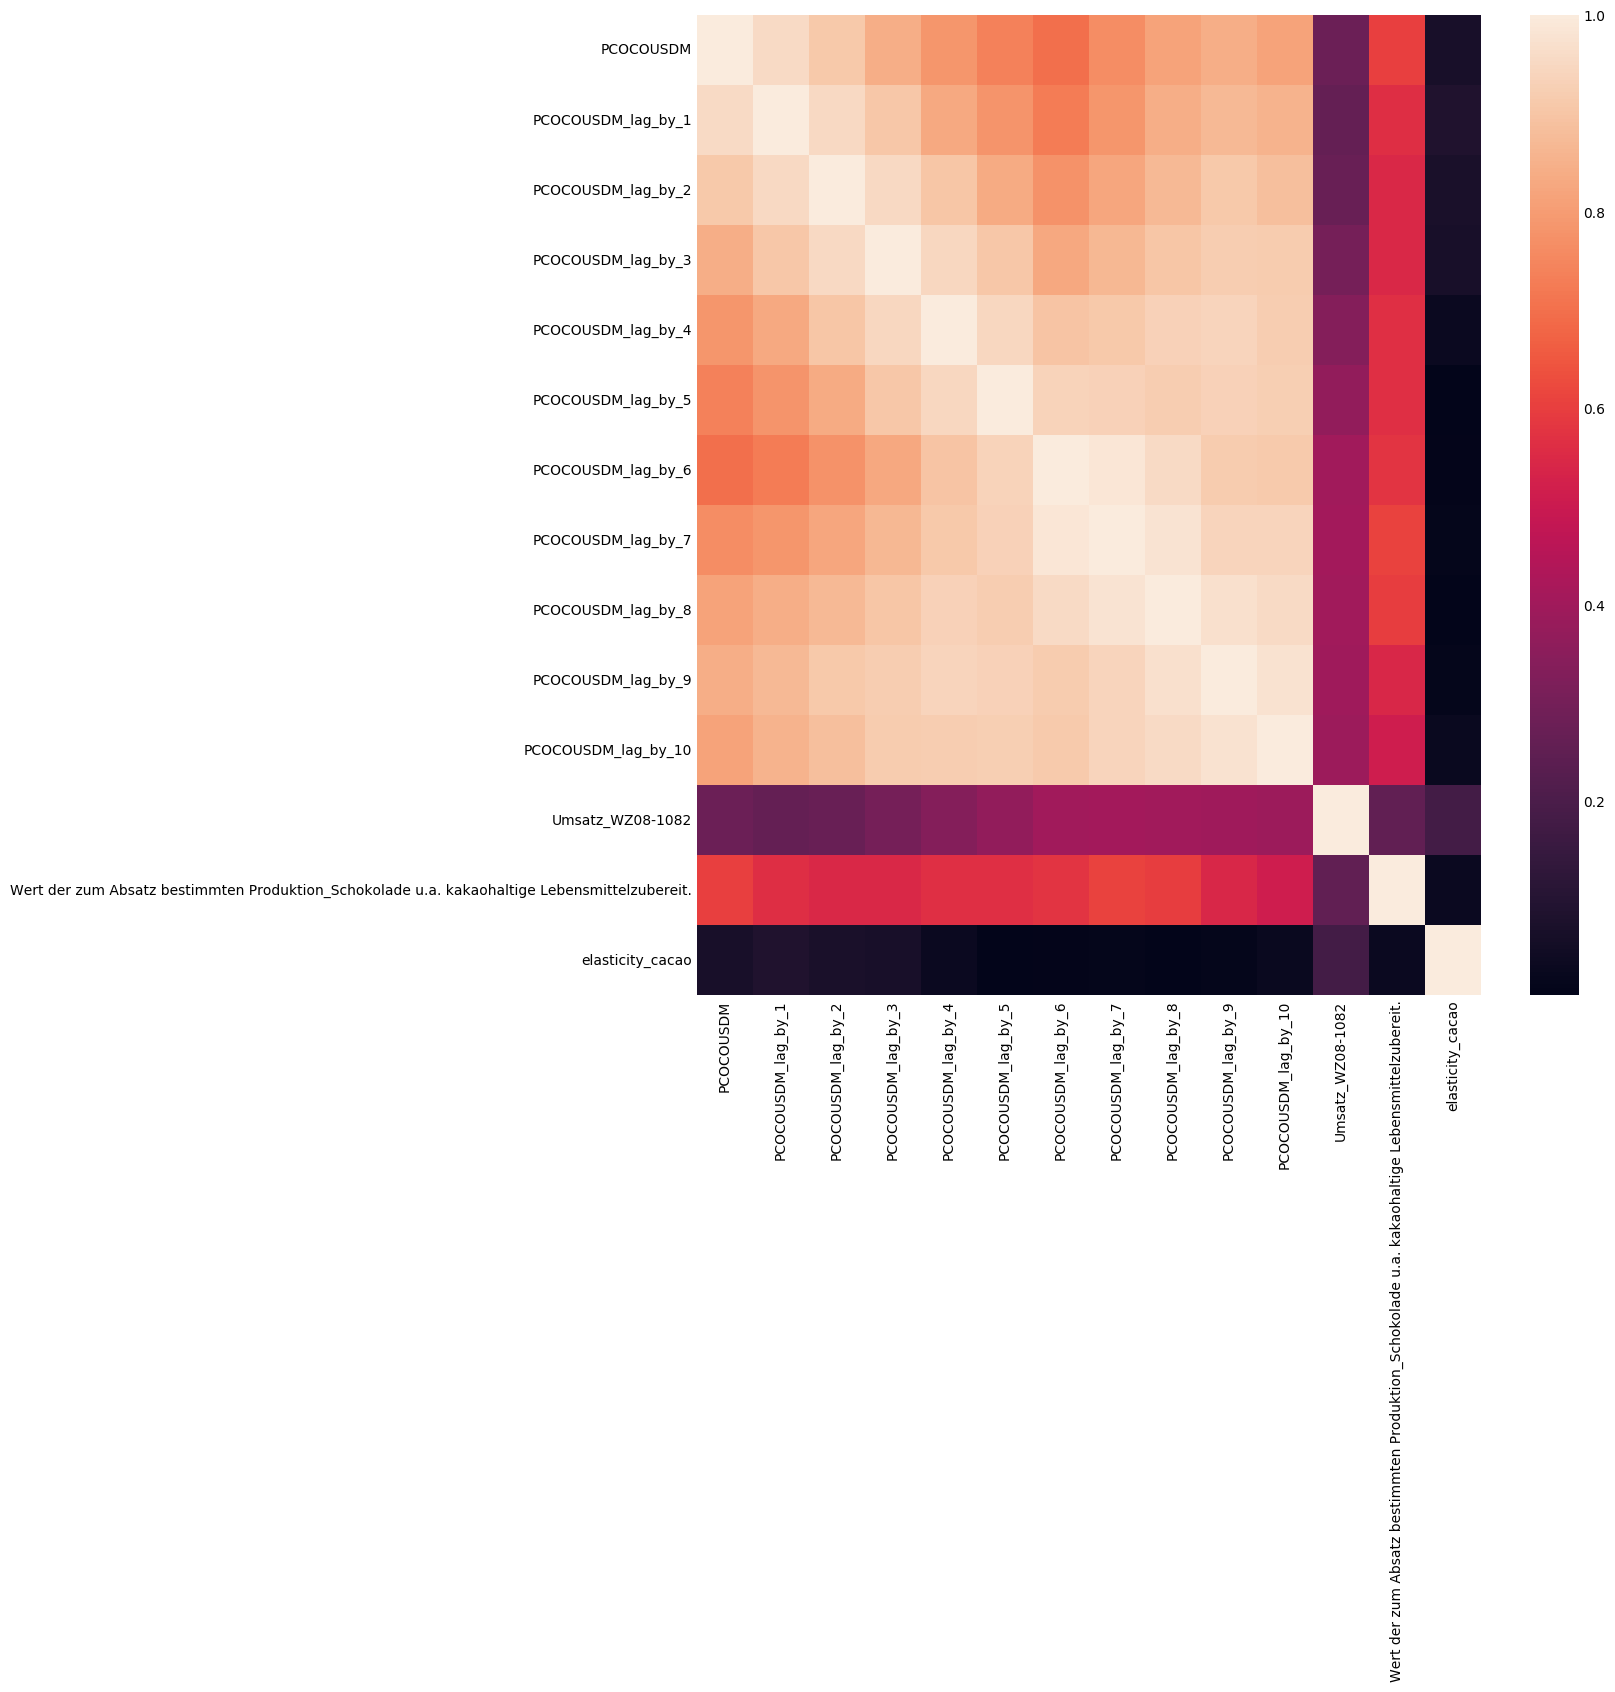

In [78]:
number_train = 70
dict_lag = {'PCOCOUSDM': [0,1,2,3,4,5,6,7,8,9,10],
            'Umsatz_WZ08-1082': [0], 
            'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.': [0],
            'elasticity_cacao': [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)

corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

### Modelez share

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


<Axes: >

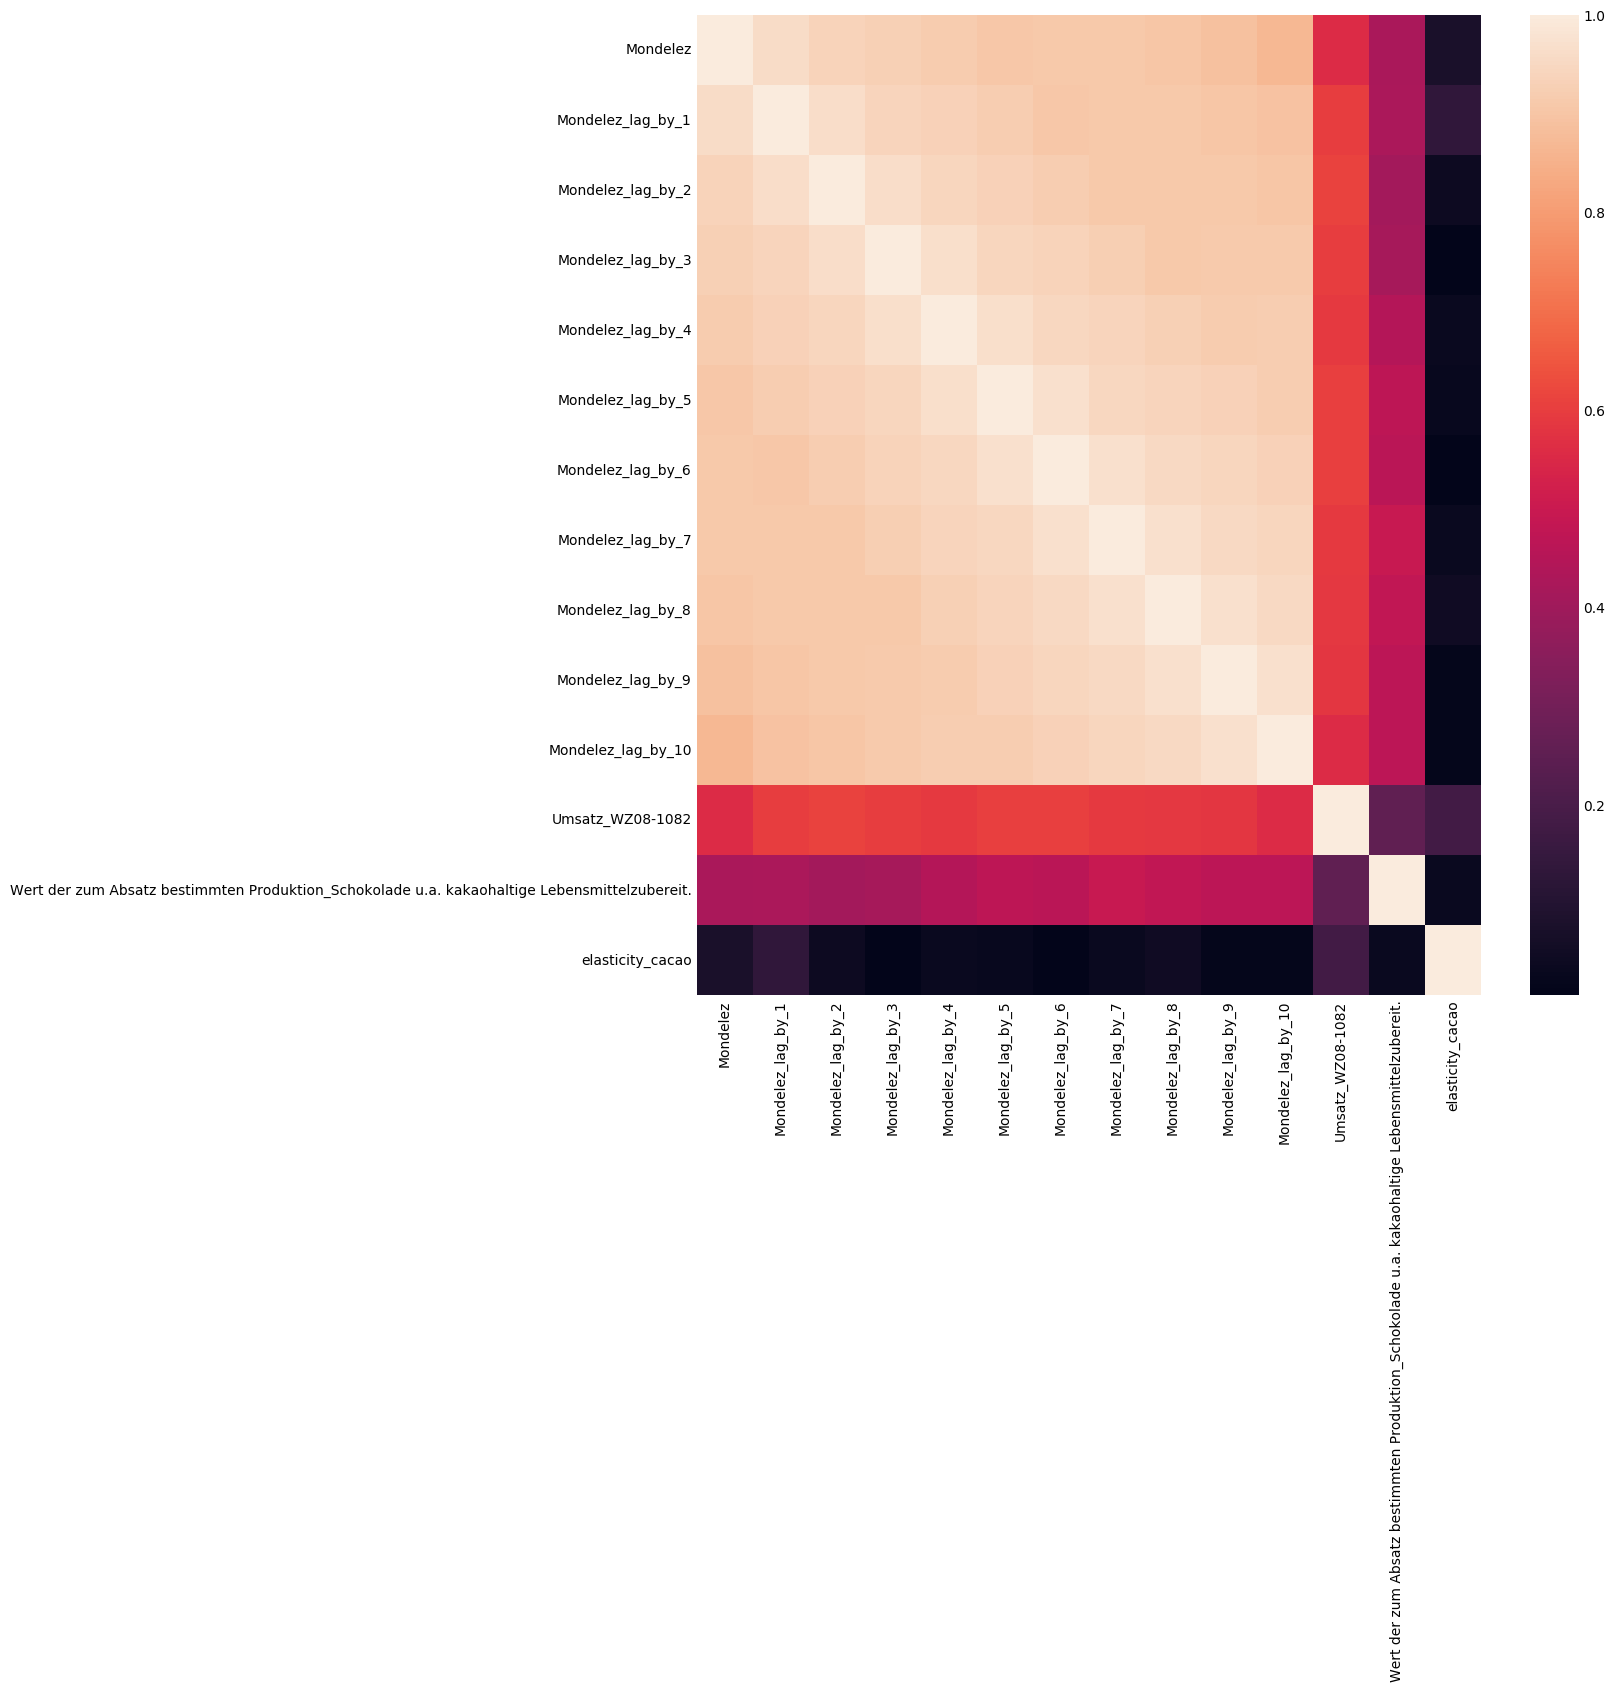

In [84]:
number_train = 70
dict_lag = {'Mondelez': [0,1,2,3,4,5,6,7,8,9,10], 
            'Umsatz_WZ08-1082': [0], 
            'Wert der zum Absatz bestimmten Produktion_Schokolade u.a. kakaohaltige Lebensmittelzubereit.': [0],
            'elasticity_cacao': [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)

corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

### global coffee price

In [89]:
df.iloc[:,143]

date
2019-01-31    134956000.0
2019-02-28    133553000.0
2019-03-31    118401000.0
2019-04-30    164383000.0
2019-05-31    176149000.0
                 ...     
2025-08-31    148256000.0
2025-09-30    142509000.0
2025-10-31    168353000.0
2025-11-30    173720000.0
2025-12-31            NaN
Name: Wert der zum Absatz bestimmten Produktion_Kaffee, geröstet, Length: 84, dtype: float64

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\imblearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


<Axes: >

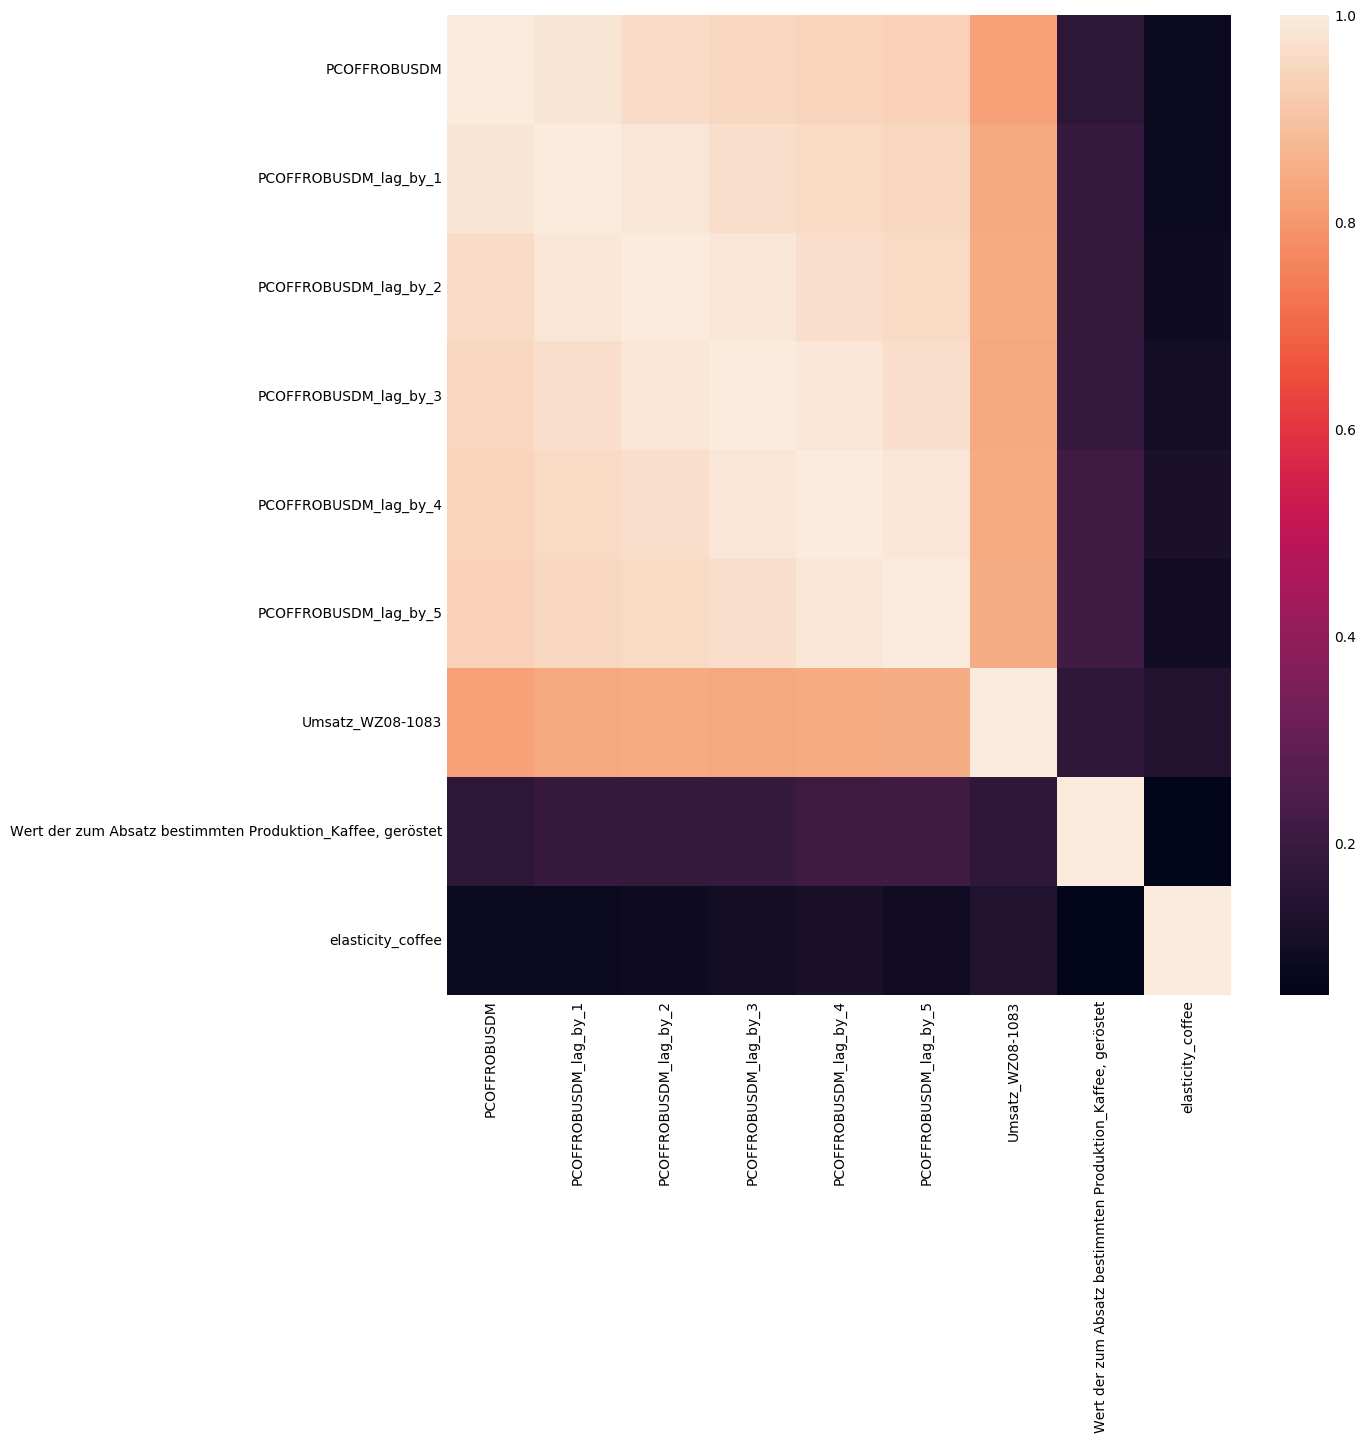

In [91]:
number_train = 70
dict_lag = {'PCOFFROBUSDM': [0,1,2,3,4,5], 
            'Umsatz_WZ08-1083': [0], 
            'Wert der zum Absatz bestimmten Produktion_Kaffee, geröstet': [0],
            'elasticity_coffee': [0]
            }
df_selected_col = df.loc[:, list(dict_lag)]
df_train = df_selected_col.iloc[:number_train, :]
df_test = df_selected_col.iloc[number_train: , :]

pipeline = Pipeline([('DaIm', DataImputation(['VPI_Schokoladen'])), ('FE', FeatureEngineer(dict_lag))])

df_train_transf = pipeline.fit_transform(df_train)
df_test_transf = pipeline.transform(df_test)

corr = df_train_transf.corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)